# Music classification

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

#hyper parameters
h_sequence = 1320
h_seg = 110
h_lr = 0.01
h_stepsize = 2
h_decay = 0.95
h_epoch = 150
h_test = 10

# transformer
ntoken = 128 # input dim
ninp = 512 # embedding dim
nhead = 8 # head num
nhid = 2048 # hidden layer dim
nlayers = 8 # Nx
nclass = 10 # output dim

# Dataset

In [2]:
from torch.utils.data import Dataset
import os
import random

class Audio(Dataset):
    def __init__(self, root, transforms, sequence, seg=1, train=True):
        random.seed(42)
        self.root = root
        self.sequence = sequence
        self.seg = seg
        class_list = os.listdir(self.root)
        # class dict
        self.class_dict = dict(zip(class_list, torch.arange(len(class_list))))
        # file
        num = len(os.listdir(self.root + '/' + class_list[0])) - 1
        idx_list = range(num)
        train_idx_list = random.sample(range(num), int(num*0.8))
        test_idx_list = set(idx_list) - set(train_idx_list)
        idx_list = train_idx_list if train else test_idx_list
        self.file_list = [
            str(class_) + '/' + str(class_) + '.' + str(idx).zfill(5) + ".wav" 
            for idx in idx_list for class_ in class_list
        ] 
        self.transforms = transforms
        
    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, idx):
        audio, sample_rate = torchaudio.load(self.root + '/' + self.file_list[idx])
        seg_num = int(audio.shape[1] / h_sequence)
        label = self.file_list[idx].split('/')
        
        if(self.transforms != None):
            audio = self.transforms(audio).squeeze()
        audio = audio[:, :self.sequence].transpose(0,1)
        audio = audio.view(int(self.sequence/self.seg), self.seg, audio.shape[1]) + 0.001
        audio = audio.log2()
        label = torch.full((1, audio.shape[1]), self.class_dict[label[0]], dtype=torch.long).squeeze()
        return {"data":audio, "label":label}

In [3]:
transforms = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=1000)

trainset = Audio("./dataset", transforms, h_sequence, h_seg, True)
testset = Audio("./dataset", transforms, h_sequence, h_seg, False)

# Waveform

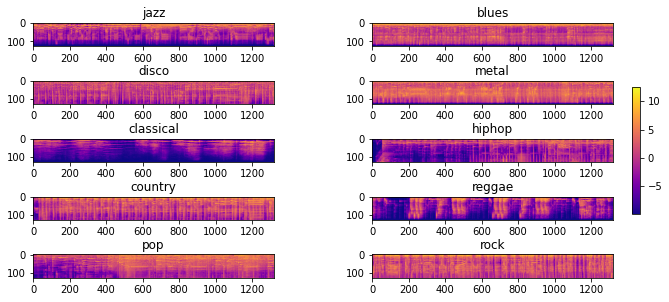

In [9]:
fig, ax = plt.subplots(5, 2, figsize=(10, 4), constrained_layout=True)
for i in range(5):
    for j in range(2):
        ax[i, j].set_title(list(trainset.class_dict.keys())[i*2 + j])
        im = ax[i, j].imshow(trainset[i*2 + j]["data"].view(h_sequence, ntoken).transpose(0,1).numpy(), cmap='plasma')
fig.colorbar(im, ax=ax, shrink=0.5)
fig.show()

# Transformer

In [5]:
class PositionEncoder(nn.Module):
    def __init__(self, n_dim, dropout=0.5, s=1000):
        super(PositionEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pos = torch.arange(0, s, dtype=torch.float).unsqueeze(1)
        div_term = 10000 ** (torch.arange(0, n_dim, 2, dtype=torch.float) / n_dim)
        pe = torch.zeros([s, n_dim])
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.shape[0]]
        return self.dropout(x)
        

class Transformer(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, nclass, dropout=0.5, mask_s=0):
        super(Transformer, self).__init__()
        self.ninp = ninp
        self.encoder = nn.Sequential(nn.Linear(ntoken, ninp),
                                     nn.Tanh())
        self.pos_encoder = PositionEncoder(ninp, dropout)
        encoderlayer = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoderlayer, nlayers)
        self.decoder = nn.Linear(ninp, nclass)
        self.init_weights()
        
        if(mask_s is not 0):
            mask = (torch.triu(torch.ones(mask_s, mask_s), diagonal=1) == 1)
            mask = mask.float().masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
            self.register_buffer("mask", mask)
        else:
            self.mask  = None
            
    def init_weights(self):
        initrange = 0.1
        self.encoder[0].bias.data.zero_()
        self.encoder[0].weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, x):         
        x = self.encoder(x)
#         x = self.pos_encoder(x)
        x = self.transformer_encoder(x, self.mask) if self.mask is not None else self.transformer_encoder(x)
        x = self.decoder(x[x.shape[0]-1,:,:])
        return x
    
model = Transformer(ntoken, ninp, nhead, nhid, nlayers, nclass, 0.3, int(h_sequence/h_seg)).cuda()

# Optimizer

In [6]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=h_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, h_stepsize, h_decay)

# Tensorboard

In [7]:
writer = SummaryWriter()

# Training

In [8]:
for epoch in range(h_epoch):
    """
    Train
    """
    total_loss = 0.0
    TP = 0 
    FP = 0
    model.train()
    for i, data in enumerate(trainset):
        optim.zero_grad()
        
        inputs, labels = data["data"].cuda(), data["label"].cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()
        
        total_loss += loss.item()
        predict = labels == torch.argmax(outputs, dim=1)
        TP += (predict == True).sum()
        FP += (predict == False).sum()
        
    precision = TP / float(TP+FP) * 100
    writer.add_scalar('Loss/train', total_loss, epoch)
    writer.add_scalar('Prediction/train', precision, epoch)
    print("[{:3d}/{:3d}] loss: {:.6f}".format(epoch+1, h_epoch, total_loss))
    
    """
    Test
    """
    if(epoch % h_test == h_test-1):
        total_loss = 0.0
        TP = 0 
        FP = 0
        model.eval()
        for i , data in enumerate(testset):            
            inputs, labels = data["data"].cuda(), data["label"].cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            predict = labels == torch.argmax(outputs, dim=1)
            TP += (predict == True).sum()
            FP += (predict == False).sum()
            
        precision = TP / float(TP+FP) * 100
        writer.add_scalar('Loss/test', total_loss, epoch/h_test)
        writer.add_scalar('Prediction/test', precision, epoch/h_test)
        print("----- Test -----")
        print("Precision: {:5.2f}%".format(precision))
        print("-----------------")
        
    scheduler.step()

[  1/150] loss: 1914.098642
[  2/150] loss: 1265.787290
[  3/150] loss: 984.427445
[  4/150] loss: 802.963128
[  5/150] loss: 662.621326
[  6/150] loss: 615.065923
[  7/150] loss: 540.457213
[  8/150] loss: 514.512806
[  9/150] loss: 467.015194
[ 10/150] loss: 451.146720
----- Test -----
Precision: 56.68%
-----------------
[ 11/150] loss: 410.374876
[ 12/150] loss: 384.214245
[ 13/150] loss: 350.836899
[ 14/150] loss: 327.243629
[ 15/150] loss: 304.831907
[ 16/150] loss: 280.873951
[ 17/150] loss: 258.849719
[ 18/150] loss: 240.517089
[ 19/150] loss: 214.685832
[ 20/150] loss: 196.864184
----- Test -----
Precision: 62.33%
-----------------
[ 21/150] loss: 177.336259
[ 22/150] loss: 162.992834
[ 23/150] loss: 141.679933
[ 24/150] loss: 126.828055
[ 25/150] loss: 112.199893
[ 26/150] loss: 101.274272
[ 27/150] loss: 87.918347
[ 28/150] loss: 81.211895
[ 29/150] loss: 68.957567
[ 30/150] loss: 60.930847
----- Test -----
Precision: 70.47%
-----------------
[ 31/150] loss: 56.735448
[ 32/15